In [71]:
import os ,sys
import numpy as np
import random as r
import cv2
import time

workpath = sys.path[0]
#print (workpath)

import matplotlib.pyplot as plt
from skimage import io,util,transform

In [72]:
def invert(Matrix):
    """Renvoi la matrice négative"""
    size = np.shape(Matrix)
    px = size[0]
    py = size[1]
    Mz = np.copy(Matrix)
    M = np.max(Matrix)
    for i in range(px):
        for j in range (py):
           Mz[i][j] = M - Matrix[i][j]
    return (Mz)

def dilation_kernel(val : int , kernel_size : tuple):
    x , y = kernel_size
    kernel = np.ones( kernel_size , np.uint8)
    for i in range(x):
        for j in range(y):
            kernel[i,j] = kernel[i,j]*val
    return kernel

def count_binary_shape(Matrix : np.array , cartography : object):
    """Compte les formes binaires ( forme composée que de 1 sur un fond de 0 UNIQUEMENT)"""

    x , y = cartography.shape
    M = cartography.binary_max

    slice_list = []
    for i in range(x):
        lenght = [  1  ]
        type = [ Matrix[i,0] ]
        for j in range(1,y):
            elt = Matrix[i,j]
            #Changement de tronçon
            if elt != type[-1] : 
                #print('changement')
                type.append(elt)
                lenght.append(1)
            #Poursuite sur le même tronçon
            else:
                lenght[-1] += 1
        slice_list.append( [type , lenght])

    #traitement tronçons
    nb_particule = []
    for i in range(x):
        slice = slice_list[i]
        les_types = slice[0]
        les_lenghts = slice[1]
        les_types_n = [l//M for l in les_types]
        nb_particule.append(sum(les_types_n))
    
    #Décompte
    s = 0
    for i in range(1 , len(nb_particule )):
        delta = nb_particule[i] - nb_particule[i-1]
        if delta > 0:
            s += delta

    return s

def find_one_binary_shape(Matrix : np.array , cartography : object):
    """Trouve une NP non présente dans la cartography"""
    
    x,y = cartography.shape
    M = cartography.binary_max
    track_list = cartography.pos_particules

    while (True):
        i_s = r.randrange(0,x)
        j_s = r.randrange(0,y)
        redo = False 
        if len(track_list) != 0:
            for couple in track_list:
                i_min = couple[0]
                i_max = couple[1]
                j_min = couple[2]
                j_max = couple[3]
                if (i_min -1 <= i_s <=i_max +1 ) and (j_min -1 <= j_s <= j_max +1):
                    redo = True

        if Matrix[i_s,j_s] == M and redo == False:
            break
    
    return i_s , j_s

def find_center(Matrix : np.array , i0 : int , j0 : int , cartography : object ):
    """Trouve le centre de la NP à partir du point (i0,j0) à l'intérieur d'une NP   """
    
    x,y = cartography.shape
    
    i = i0
    j = j0
    #recherche bord gauche
    while(True):
        if (j == 0) or Matrix[i][j-1] == 0:
            j_g = j
            j = j0
            break
        j-=1
    
    #recherche bord droit
    while(True):
        if (j == y-1) or Matrix[i][j+1] == 0:
            j_d = j
            break
        j+=1
  
    j_c = (j_d + j_g)//2
    j = j_c

    #recherche bord haut
    while(True):
        if (i == 0) or Matrix[i-1][j] == 0:
            i_h = i
            i = i0
            break
        i-=1
 
    #recherche bord bas
    while(True):
        if (i == x-1) or Matrix[i+1][j] == 0:
            i_b = i
            break
        i+=1

    i_c  = (i_b + i_h)//2

    return i_c , j_c

def frame (Matrix : np.array , i0 : int , j0 : int , cartography : object):
    """ Cadre NP à partir des coordonnées du centre (i0,j0)"""
    M = cartography.binary_max
    x , y = cartography.shape
    
    i = 0
    j = 0
    while(True):
        if 0<i0+i<x-1 and 0<j0+j<y-1:
            upper_band = Matrix[i0-i-1 , j0-1-i:j0+2+i]
            lower_band = Matrix[i0+i+1 , j0-1-i:j0+2+i]
            left_band  = Matrix[i0-i:i0+1+i , j0-i-1]
            right_band = Matrix[i0-i:i0+1+i , j0+i+1]
            new_zone = np.concatenate((upper_band,lower_band,left_band,right_band))
            if M not in new_zone:
                break
            else:
                i+=1
                j+=1
        else:
            break
    
    i_start = i0 - i
    i_end   = i0 + i
    j_start = j0 - j
    j_end   = j0 + j

    return [i_start , i_end , j_start , j_end]

In [73]:
def extract (img_matrix : np.array):
    
    class cartography:
        shape : np.array
        nb_particules : int
        pos_particules : np.array
        binary_max : int
    
    cartography.shape = np.shape(img_matrix)
    x = cartography.shape[0]
    y = cartography.shape[1]
    cartography.pos_particules = []
    
    #masque
    img_mask = cv2.fastNlMeansDenoising(img_matrix , h=10 , templateWindowSize=7 , searchWindowSize=21)
    img_mask = cv2.GaussianBlur (img_mask ,ksize=(21,21),sigmaX=5)
    img_mask = cv2.threshold(img_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img_mask = cv2.dilate(img_mask,kernel=dilation_kernel(255,(5,5)),iterations=4)
    
    cartography.binary_max = np.max(img_mask)
    cartography.nb_particules = count_binary_shape(Matrix=img_mask,cartography=cartography)

    for k in range (cartography.nb_particules):
        #Trouver NP qui a pas encore été traitée
        i_start , j_start = find_one_binary_shape(Matrix=img_mask ,cartography=cartography)
        #Trouver centre NP + stabilité centre
        i_c0 , j_c0 = find_center(Matrix=img_mask,i0=i_start,j0=j_start,cartography=cartography)
        while(True):
            i_c , j_c = find_center(Matrix=img_mask,i0=i_start,j0=j_start,cartography=cartography)
            if i_c != i_c0 and j_c != j_c0:
                i_c0 = i_c
                j_c0 = j_c
            else:
                break
        #Cadrer NP à partir du centre
        list_pos = frame(Matrix=img_mask,i0=i_c0,j0=j_c0,cartography=cartography)
        cartography.pos_particules.append(list_pos)
    
    cartography.pos_particules = np.array(cartography.pos_particules)
        
    return cartography

def show_extracted_images (Matrix : np.array , cartography : object):
    x , y = cartography.shape
    for position in cartography.pos_particules:
        i_start , i_end , j_start , j_end = position
        extracted_img = util.crop(Matrix,((i_start,x-1-i_end),(j_start,y-1-j_end)),copy = True)
        plt.figure()
        plt.imshow(extracted_img,cmap='gray')

def get_extracted_images(Matrix : np.array , cartography : object):
    x , y = cartography.shape
    list_extracted_img = []
    Matrix = cv2.fastNlMeansDenoising(Matrix , h=10 , templateWindowSize=7 , searchWindowSize=21)
    for position in cartography.pos_particules:
        i_start , i_end , j_start , j_end = position
        extracted_img = util.crop(Matrix,((i_start,x-1-i_end),(j_start,y-1-j_end)),copy=True)
        #img = transform.resize(extracted_img , (64,64)   )
        list_extracted_img.append(np.array(extracted_img))
    
    return np.array(list_extracted_img)

def save_extracted_images(Matrix : np.array , cartography : object, folder_name : str):
    x , y = cartography.shape
    list_extracted_img = []
    Matrix = cv2.fastNlMeansDenoising(Matrix , h=10 , templateWindowSize=7 , searchWindowSize=21)
    for position in cartography.pos_particules:
        i_start , i_end , j_start , j_end = position
        extracted_img = util.crop(Matrix,((i_start,x-1-i_end),(j_start,y-1-j_end)),copy=True)
        #img = transform.resize(extracted_img , (64,64)   )
        list_extracted_img.append(np.array(extracted_img))

    if not os.path.exists(f'{workpath}\\{folder_name}'):
        os.makedirs(f'{workpath}\\{folder_name}')

    for i in range(len(list_extracted_img)):
        img = list_extracted_img[i]
        x_img , y_img = np.shape(img)
        img_name = str(i) + '.jpg'
        #print (x_img , y_img)
        if x_img != 0 and y_img != 0:
            plt.imsave(f'{workpath}\\{folder_name}\\{img_name}' , img , cmap = 'gray' , format='jpg')

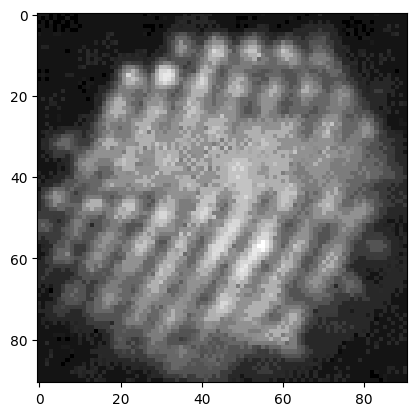

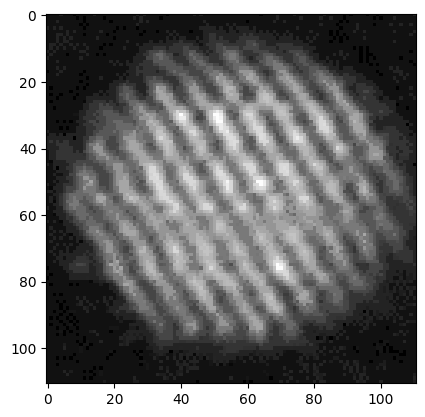

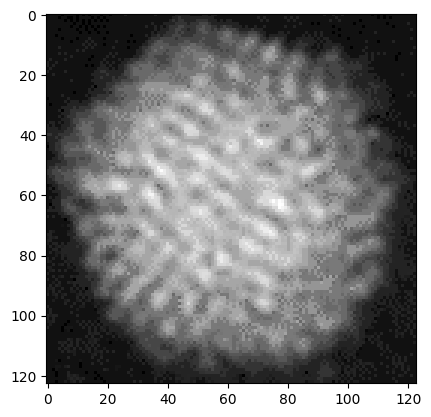

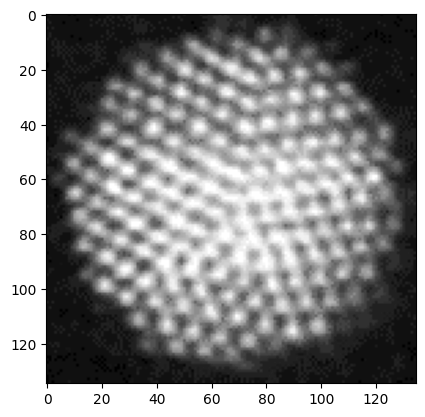

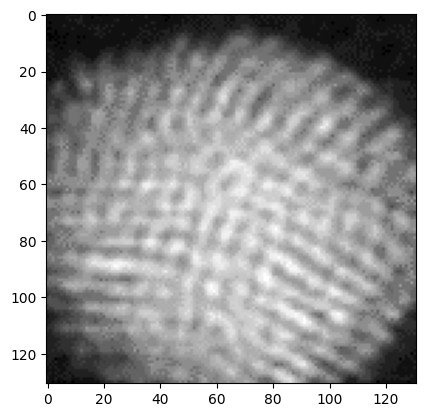

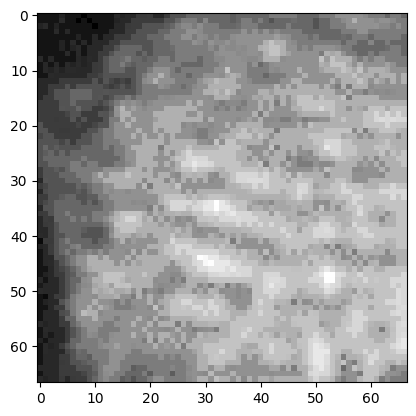

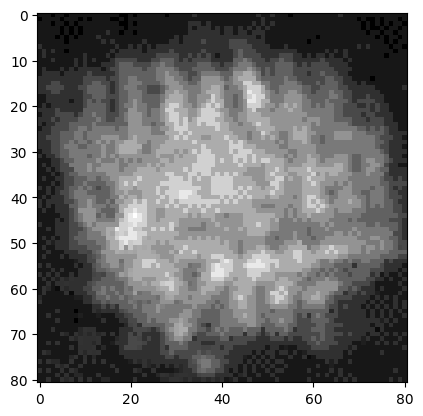

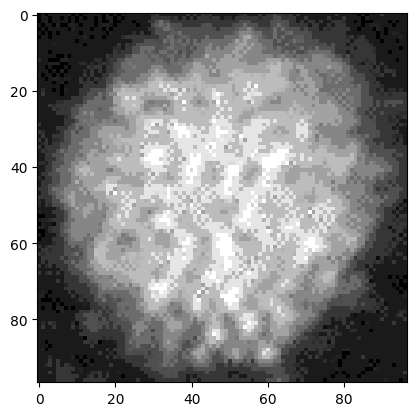

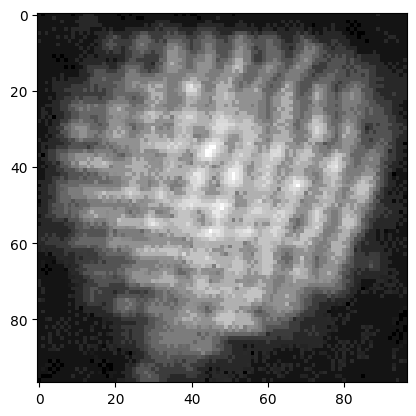

In [74]:
img = cv2.imread(f'{workpath}\\NP32.png',0)
#img = invert (img)
#plt.figure()
#plt.imshow(img , cmap='gray')

#img_mask = cv2.fastNlMeansDenoising(img , h=10 , templateWindowSize=7 , searchWindowSize=21)
#img_mask = cv2.GaussianBlur (img_mask ,ksize=(21,21),sigmaX=5)
#img_mask = cv2.threshold(img_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#img_mask = cv2.dilate(img_mask,kernel=dilation_kernel(255,(5,5)),iterations=3)

#plt.figure()
#plt.imshow(img_mask , cmap='gray')

t1 = time.time()
cartography = extract(img_matrix=img)
t2 = time.time() 

save_extracted_images(Matrix= img , cartography=cartography ,folder_name = "test_img1")
show_extracted_images(Matrix=img , cartography=cartography)


In [75]:
print ( cartography.shape)
#print ( cartography.binary_max)
print ( cartography.nb_particules)
print ( cartography.pos_particules)

print (t2 - t1)

(560, 903)
9
[[422 512 698 788]
 [200 310 539 649]
 [ 68 190 737 859]
 [ 10 144  55 189]
 [429 559 385 515]
 [483 549 836 902]
 [ 48 128 386 466]
 [311 407 103 199]
 [ 91 187 245 341]]
0.5008804798126221
